In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [17]:
def abrirImagenesEscaladas( carpeta, escala=32 ):
    # abre todas las imagenes de la carpeta, y las escala de tal forma que midan (escala x escala)px
    # devuelve las imagenes aplanadas -> vectores de tamano escala^2 con valores entre 0 y 1
    imagenes = []

    for dirpath, dirnames, filenames in os.walk(carpeta):
        for file in filenames:
            if file.endswith('DS_Store'):
                continue
            img = Image.open( os.path.join(carpeta, file) )
            img = img.resize((escala, escala))
            img.convert('1')
            img = np.asarray(img)
            if len(img.shape)==3:
                img = img[:,:,0].reshape((escala**2 )) / 255
            else:
                img = img.reshape((escala**2 )) / 255
            
            imagenes.append( img )

    return imagenes

In [18]:
# Data
if(False):
    img_train_sin_neumonia = abrirImagenesEscaladas('./chest_xray/train/NORMAL/')
    img_train_neumonia = abrirImagenesEscaladas('./chest_xray/train/PNEUMONIA/') # NO FUNCIONA :(
    img_test_sin_neumonia = abrirImagenesEscaladas('./chest_xray/test/NORMAL/')
    img_test_neumonia = abrirImagenesEscaladas('./chest_xray/test/PNEUMONIA/')

    data = (img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia)


In [19]:
def balancear_datos(imagenes_entrenamiento):

    img_train_sin_neumonia = imagenes_entrenamiento[0]
    img_train_neumonia =imagenes_entrenamiento[1]
    img_test_sin_neumonia =imagenes_entrenamiento[2]
    img_test_neumonia = imagenes_entrenamiento[3]

    # MAX NUMBER OF IMAGES
    n_train = min(len(img_train_sin_neumonia), len(img_train_neumonia))
    n_test = min(len(img_test_sin_neumonia), len(img_test_neumonia))

    # BALANCE
    img_train_sin_neumonia = img_train_sin_neumonia[:n_train]
    img_train_neumonia = img_train_neumonia[:n_train]
    img_test_sin_neumonia = img_test_sin_neumonia[:n_test]
    img_test_neumonia = img_test_neumonia[:n_test]

    
    return (img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia)

In [20]:
data = balancear_datos(data)

# EJERCISIO 1

In [21]:
def L(i,w,b):
    """_summary_

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        probabolidad: 0 < p < 1: Probabilidad de que la imagen sea un 1 (Tiene neumonia)
    """
    tan = np.tanh(np.dot(w,i)+b)
    return (tan + 1)/2

(1−t0^2)⋅((1+t0)/2−d)⋅i
t0=tanh(b+W⊤⋅i)

In [22]:
# Derivada de L con respecto a W
def L_w(i,w,b,d):
    """_summary_

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        Vector: Gradiente de la probabilidad con respecto a los pesos
    """
    # t0=tanh(b+W⊤⋅i)
    #return: (1−t0^2)⋅((1+t0)/2−d)⋅i
    
    t0 = np.tanh(np.dot(w,i)+b)
    return (1-t0**2)*(((1+t0)/2)-d) * i

In [23]:
# Derivada de L con respecto a b
def L_b(i,w,b,d):
    """_summary_

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        Float: Gradiente de la probabilidad con respecto al bias
    """
    #t0=tanh(b+W⊤⋅i)
    #(1−t0^2)⋅((1+t0)/2−d)   
    t0 = np.tanh(np.dot(w,i)+b)
    return (1-t0**2)*(((1+t0)/2)-d)

# EJERCISIO 2

In [24]:
def desenso_gradiente(i, w, b, d, alpha=0.1):
    """_summary_

    Args:
        imagenes_entrenamiento (List): Lista de imagenes de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate

    Returns:
        Tuple: Pesos y bias actualizados

    """
    w = w - alpha * L_w(i,w,b,d)
    b = b - alpha * L_b(i,w,b,d)
    return w,b



# Ejercisio 3

In [81]:
def train(datos, alpha=0.1, epochs = 5,seed = 42):
    """_summary_

    Args:
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate
        epochs (Int): Numero de iteraciones

    Returns:
        Tuple: Pesos y bias actualizados
    """
    # inicioamos con pesos aleatorios
    # set numpy seed
    

    datos_sin_neumonia = datos[0]
    datos_con_neumonia = datos[1]

    np.random.seed(seed)
    w = np.random.randn(datos_sin_neumonia[0].shape[0])
    b = np.random.randn(1)
    
    
    print(len(datos_sin_neumonia)+len(datos_con_neumonia),len(datos_sin_neumonia)/len(datos_con_neumonia))
    
    error = 0
    errores = []
    for _ in range(epochs):  
        error = 0

        label = 0
        for i in datos_sin_neumonia: 
            w,b = desenso_gradiente(i,w,b,label,alpha)
            error += (L(i,w,b) - label)**2 # Falta arreglar esto
        label = 1
        for i in datos_con_neumonia:
            w,b = desenso_gradiente(i,w,b,label,alpha)
            error += (L(i,w,b) - label)**2 # Falta arreglar esto

        errores.append(error)
        alpha = alpha * 0.95
        # print overight in line
        print(f"\r{error}",end='',)
    
    plt.plot(errores)
    plt.show()

    return w,b

In [89]:
def test(w,b,datos):
    """_summary_

    Args:
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 

    Returns:
        Float: Accuracy
    """
    datos_sin_neumonia = datos[0]
    datos_con_neumonia = datos[1]
    correctos = 0
    for i in datos_sin_neumonia:
        if L(i,w,b) < 0.5:
            correctos += 1
    for i in datos_con_neumonia:
        if L(i,w,b) >= 0.5:
            correctos += 1
    return correctos/(len(datos_sin_neumonia)+len(datos_con_neumonia))

2698 1.0
[319.15240853]]

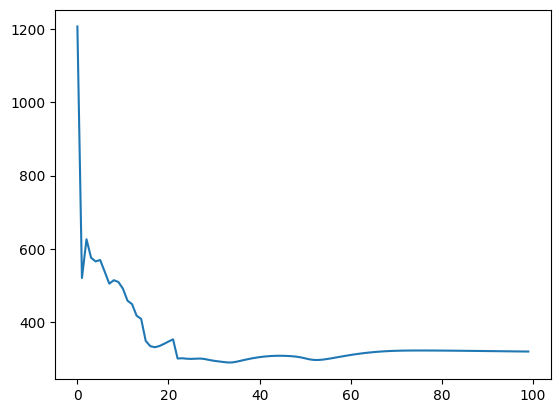

0.6495726495726496

In [93]:
train_sin, train_con, test_sin, test_con = data

w_res, b_res = train(
    (train_sin, train_con),
    alpha=0.005,
    epochs = 100,
    seed = 45
    )
test(w_res,b_res,(test_sin,test_con))